In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
file_dir = "/kaggle/input/plastik"
os.listdir(file_dir)

['hdpe_container',
 'pvc_unclear',
 'hdpe_botol',
 'ps',
 'pp_tutup_botol',
 'pp_botol',
 'pp_sedotan',
 'pet',
 'pp_container',
 'ldpe_bag',
 'ldpe_botol',
 'pvc_clear',
 'hdpe_tutup_botol']

In [3]:
img_height, img_width = (200, 200)
IMG_SIZE = (img_height, img_width)
IMG_SIZE_WITH_RGB = IMG_SIZE+(3,)
batch_size = 32

data_directory = "/kaggle/input/plastik"

In [4]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory=data_directory,
    subset="training",
    validation_split=0.2,
    seed=2023,
    image_size=IMG_SIZE,
    batch_size=batch_size
)

validation_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory=data_directory,
    subset="validation",
    validation_split=0.2,
    seed=2023,
    image_size=IMG_SIZE,
    batch_size=batch_size
)

Found 1909 files belonging to 13 classes.
Using 1528 files for training.
Found 1909 files belonging to 13 classes.
Using 381 files for validation.


In [5]:
train_data.class_names

class_names = train_data.class_names

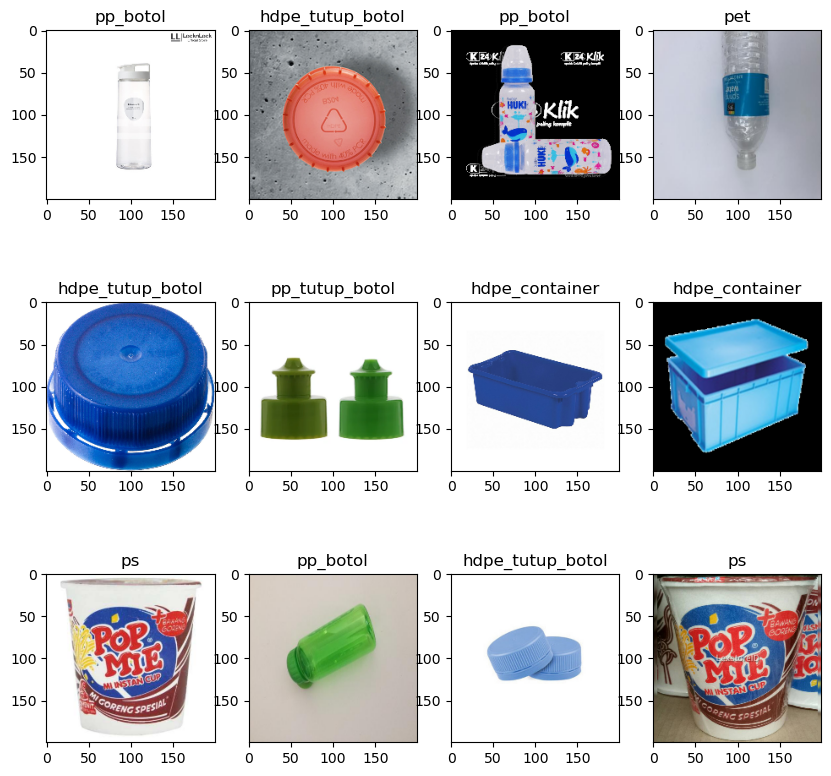

In [6]:
image_batch, label_batch = next(iter(train_data))

plt.figure(figsize=(10,10))
for i in range (12):
    
    ax = plt.subplot(3,4, i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    label = class_names[label_batch[i]]
    plt.title(label)


In [7]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SIZE_WITH_RGB,
    include_top=False,
    weights="imagenet"
)
base_model.trainable = True

9406464/9406464 [==============================] - 1s 0us/step


In [8]:
image_batch, label_batch = next(iter(train_data))
feature_batch = base_model(image_batch)

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_avg = global_average_layer(feature_batch)

prediction_layer = tf.keras.layers.Dense(len(class_names))

In [9]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
  tf.keras.layers.experimental.preprocessing.RandomContrast(0.2),
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
])

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy') >= 0.8):
      self.model.stop_training = True

callbacks = myCallback()

In [10]:
dropout_param = 0.4
learning_rate = 1e-4

model = tf.keras.Sequential([
    tf.keras.Input(shape=IMG_SIZE_WITH_RGB),
    data_augmentation,
    tf.keras.layers.Lambda(preprocess_input),
    base_model,   
    global_average_layer,
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(dropout_param),
    tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dense(256, activation="relu"),
#     tf.keras.layers.Dropout(dropout_param),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dense(512, activation="relu"),
#     tf.keras.layers.Dropout(dropout_param),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dense(1024, activation="relu"),
#     tf.keras.layers.Dropout(dropout_param),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dense(2048, activation="relu"),
#     tf.keras.layers.Dropout(dropout_param),
#     tf.keras.layers.BatchNormalization(),
    prediction_layer
])



model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [11]:
initial_epochs = 300

loss0, accuracy0 = model.evaluate(validation_data)
print(loss0, accuracy0)

12/12 [==============================] - 11s 166ms/step - loss: 2.9488 - accuracy: 0.0682
2.9487509727478027 0.06824146956205368


In [12]:
history = model.fit(train_data,
                    epochs=initial_epochs,
                    validation_data=validation_data, callbacks=[callbacks])

Epoch 1/300
48/48 [==============================] - 75s 798ms/step - loss: 2.6267 - accuracy: 0.2134 - val_loss: 2.1677 - val_accuracy: 0.3097
Epoch 2/300
48/48 [==============================] - 34s 638ms/step - loss: 1.6960 - accuracy: 0.4509 - val_loss: 1.7822 - val_accuracy: 0.4488
Epoch 3/300
48/48 [==============================] - 38s 718ms/step - loss: 1.3097 - accuracy: 0.5759 - val_loss: 1.4820 - val_accuracy: 0.5538
Epoch 4/300
48/48 [==============================] - 36s 656ms/step - loss: 1.0737 - accuracy: 0.6479 - val_loss: 1.3217 - val_accuracy: 0.6142
Epoch 5/300
48/48 [==============================] - 34s 644ms/step - loss: 0.9177 - accuracy: 0.7088 - val_loss: 1.2263 - val_accuracy: 0.6562
Epoch 6/300
48/48 [==============================] - 34s 647ms/step - loss: 0.8337 - accuracy: 0.7369 - val_loss: 1.0963 - val_accuracy: 0.6745
Epoch 7/300
48/48 [==============================] - 34s 647ms/step - loss: 0.7713 - accuracy: 0.7415 - val_loss: 1.0446 - val_accuracy:

In [13]:
import pickle

model_file_path = "New3_MobileNetV2_1e-4_80Split_Adam_Dense_with02Dropout.pkl"
with open(model_file_path, "wb") as file:
    pickle.dump(model, file)

In [21]:
model.save("h5_Fixed_MobileNetV2_1e-4_80Split_Adam_Dense_with02Dropout.h5")

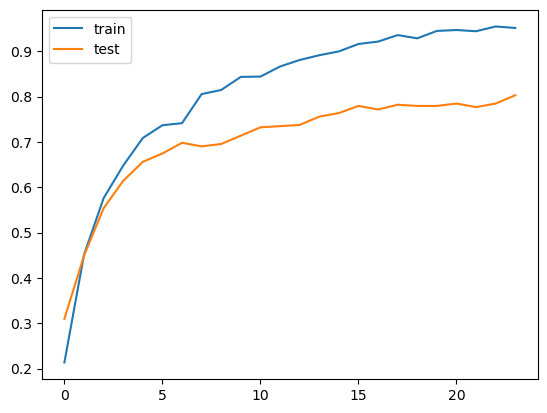

In [15]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train', 'test'], loc='upper left')


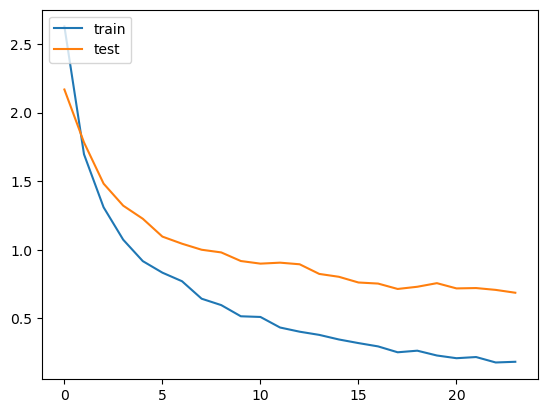

In [16]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'test'], loc='upper left')

1/1 [==============================] - 0s 28ms/step
[[-1.2249757  -0.68948346  1.0750109   2.3400874  -1.1821401   0.9266406
   0.5547581   0.01104424  1.5255172  -0.44043845 -2.5637717   1.0327282
  -0.16025905]]
ldpe_bag


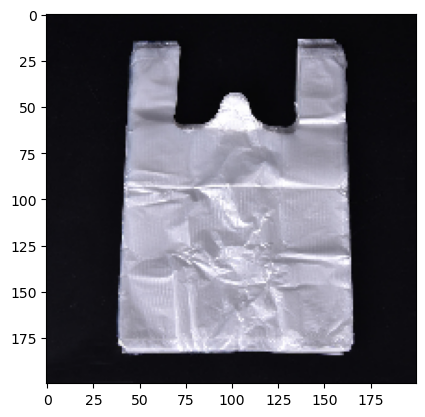

In [24]:
import os

image = tf.keras.preprocessing.image.load_img("/kaggle/input/plastik/ldpe_bag/ldpe_bag_0.png", target_size=(200,200))
plt.imshow(image)
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])
input_arr = input_arr.astype('float32') / 255
result = model.predict(input_arr)
print(result)
print(class_names[np.argmax(result)])